In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML1M'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[dftrain,dfvalid,results_concat]=pickle.load(open(f'{DATAPATH}/df_side_cold_runother.pkl','rb'))

In [4]:
df=pd.concat([dftrain,dfvalid[dftrain.columns]],axis=0)

In [5]:
user_to_idx={j:i+1 for i, j in enumerate(df['userId'].unique())}
item_to_idx={j:i+1 for i,j in enumerate(df['itemId'].unique())}
idx_to_user={i+1:j for i, j in enumerate(df['userId'].unique())}
idx_to_item={i+1:j for i,j in enumerate(df['itemId'].unique())}

In [6]:
dftrain['user_idx']=[user_to_idx[i] for i in dftrain['userId']]
dftrain['item_idx']=[item_to_idx[i] for i in dftrain['itemId']]

In [7]:
dfvalid['user_idx']=[user_to_idx[i] for i in dfvalid['userId']]
dfvalid['item_idx']=[item_to_idx[i] for i in dfvalid['itemId']]

In [8]:
pickle.dump([df, dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx],open(f'{DATAPATH}/reads.pkl','wb'))

### Dataset and DataLoader

In [9]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [10]:
dstrain=cfdata(dftrain[['user_idx','item_idx']],dftrain['rating'])
dsvalid=cfdata(dfvalid[['user_idx','item_idx']],dfvalid['rating'])

In [11]:
dftrain.shape

(895738, 392)

In [12]:
bs=64

In [13]:
dltrain=DataLoader(dstrain,bs,True)

In [14]:
dlvalid=DataLoader(dsvalid,bs,False)

In [15]:
len(user_to_idx),len(item_to_idx)

(6040, 3706)

## Model Architecture

In [16]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=25
n_emb_item=25
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05


In [17]:
n_users

6040

In [18]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e=dropout_e
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)

        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

       
    def forward (self,Xb,Yb):               
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))

        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [19]:
n_users

6040

In [20]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [21]:
cfobj

cf(
  (emb_user): Embedding(6041, 25)
  (emb_item): Embedding(3707, 25)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [22]:
for Xb, Yb in dltrain:
    break

In [23]:
Xb.shape, Yb.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [24]:
cfobj.forward(Xb,Yb)

(tensor([[4.8665],
         [4.7776],
         [1.2330],
         [4.9396],
         [3.9664],
         [3.2082],
         [2.3126],
         [4.7531],
         [1.8818],
         [4.8793],
         [4.3598],
         [4.9370],
         [2.8825],
         [3.9926],
         [2.3257],
         [2.8757],
         [1.2889],
         [1.1052],
         [4.6572],
         [4.2677],
         [1.4131],
         [4.3294],
         [1.8394],
         [3.3024],
         [3.6478],
         [2.0745],
         [1.8344],
         [1.1325],
         [2.1193],
         [4.8376],
         [1.0647],
         [2.2648],
         [4.9432],
         [1.2542],
         [4.2381],
         [4.4885],
         [3.1310],
         [4.5297],
         [4.1998],
         [3.1343],
         [3.7366],
         [1.2614],
         [2.0287],
         [1.9717],
         [1.2695],
         [2.7906],
         [1.1370],
         [1.6234],
         [4.8605],
         [2.8116],
         [3.9422],
         [3.9050],
         [4.

## Learner

In [49]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse",
                cycle_const=False):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_const=cycle_const
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    if self.cycle_const == False:
                        self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [97]:
if 1==1:
    del cfobj
    torch.cuda.empty_cache()

In [98]:
device='cuda:0'

In [99]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [100]:
cfobj=cfobj.to(device)

In [101]:
cfobj

cf(
  (emb_user): Embedding(6041, 25)
  (emb_item): Embedding(3707, 25)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [102]:
len(dltrain)

13996

In [103]:
wd=0
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,5000,0.25,cycle_mult=0)

In [104]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

Batch:5000 3.1021770522117613  
Batch:10000 2.5510578604280947  


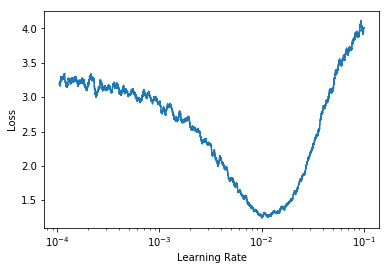

In [105]:
learner.plot_lrs(100)

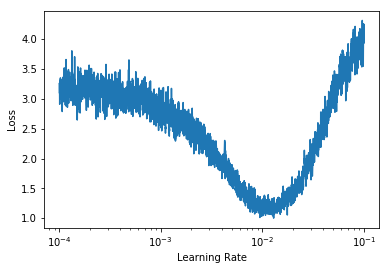

In [35]:
learner.plot_lrs(10)

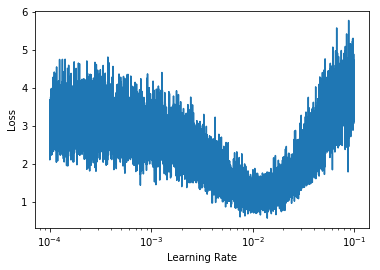

In [36]:
learner.plot_lrs(1)

In [124]:
del cfobj
torch.cuda.empty_cache()

In [126]:
wd=1e-6

In [127]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)
cfobj=cfobj.to(device)

In [128]:
device

'cuda:0'

In [129]:
cfobj

cf(
  (emb_user): Embedding(6041, 25)
  (emb_item): Embedding(3707, 25)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [130]:
optimizer=torch.optim.Adam(cfobj.parameters(),lr=1e-2,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=2,start_lr=1e-2,end_lr=5e-3,wd_mult=1.2)

In [131]:
learner.run_epochs(dltrain,dlvalid,15)

Epoch:0 Learning rate 0.01 Weight Decay 1e-06 Train Loss:1.2342072905843242                 Valid Loss:1.1678680041160454 Train RMSE:1.1005589032930216 Valid RMSE:1.0647046714990769 Train MSE:1.2342072905843242 Valid MSE:1.1678680041160454                 Train MAE:0.8640098184236427 Valid MAE:0.8409687129179539
Epoch:1 Learning rate 0.007071067811865476 Weight Decay 1.2e-06 Train Loss:0.9642379445096498                 Valid Loss:1.0100798330931888 Train RMSE:0.9768973213174288 Valid RMSE:0.9903872785336377 Train MSE:0.9642379445096498 Valid MSE:1.0100798330931888                 Train MAE:0.7635061983407719 Valid MAE:0.7839064560488405
Epoch:2 Learning rate 0.005000000000000001 Weight Decay 1.44e-06 Train Loss:0.8313389509515988                 Valid Loss:0.920276282776081 Train RMSE:0.9070110506447105 Valid RMSE:0.9442546129733151 Train MSE:0.8313389509515988 Valid MSE:0.920276282776081                 Train MAE:0.711442543435911 Valid MAE:0.7506361411746411
Epoch:3 Learning rate 0.

In [74]:
learner.start_lr=7e-3
learner.lr=7e-3
for param in optimizer.param_groups:
    param['lr']=7e-3

In [75]:
learner.run_epochs(dltrain,dlvalid,3)

Epoch:0 Learning rate 0.02 Weight Decay 5e-06 Train Loss:1.9025736793973644                 Valid Loss:2.064982513160846 Train RMSE:1.370992410458385 Valid RMSE:1.4203820747355163 Train MSE:1.9025736793973644 Valid MSE:2.064982513160846                 Train MAE:1.0623491609495141 Valid MAE:1.1205066185894001


KeyboardInterrupt: 

In [47]:
results_concat[:40]

,method,mse,rmse,mae,r2_score,Cold Start Group
0,biasedmatrixfactorization,0.762661,0.873305,0.686658,0.419384,No-cold-start
1,biasedmatrixfactorization,0.975590,0.987719,0.787813,0.184044,User-Cold-Start
2,biasedmatrixfactorization,1.004593,1.002294,0.866920,-0.205512,Item-Cold_start
3,biasedmatrixfactorization,1.161611,1.077781,1.000000,-0.161611,User-Item-cold-start
0,biasedmatrixfactorization,0.762661,0.873305,0.686658,0.419384,0
1,biasedmatrixfactorization,0.975705,0.987778,0.788064,0.184027,1
0,biasedmatrixfactorization,0.781557,0.884057,0.695652,0.402036,0
0,svdplusplus,0.760565,0.872104,0.681210,0.420979,No-cold-start
1,svdplusplus,0.965663,0.982682,0.789363,0.192346,User-Cold-Start
2,svdplusplus,1.005146,1.002569,0.877412,-0.206175,Item-Cold_start


In [46]:
results_concat[40:]

,method,mse,rmse,mae,r2_score,Cold Start Group
1,itemknnpearson,0.968187,0.983965,0.787255,0.190315,1
0,itemknnpearson,0.817426,0.904116,0.707335,0.374592,0
0,itemknncosine,0.813202,0.901777,0.706219,0.380906,No-cold-start
1,itemknncosine,0.968217,0.983980,0.787066,0.190210,User-Cold-Start
2,itemknncosine,0.940441,0.969763,0.842502,-0.128529,Item-Cold_start
3,itemknncosine,1.161611,1.077781,1.000000,-0.161611,User-Item-cold-start
0,itemknncosine,0.813202,0.901777,0.706219,0.380906,0
1,itemknncosine,0.968187,0.983965,0.787255,0.190315,1
0,itemknncosine,0.826949,0.909367,0.713406,0.367307,0
0,itemavg,0.986194,0.993073,0.789912,0.249207,No-cold-start


In [53]:
learner.generate_scores=True

In [54]:
learner.run_epoch(dlvalid,False)

(0.765174284478508, 0.6913009601924905, 0.8623963581479989)

In [55]:
np.concatenate(learner.scores)

array([3.9013758, 3.5500436, 3.4768884, ..., 3.3399463, 2.869813 ,
       3.1324563], dtype=float32)

In [56]:
dfvalid['pred_cf']=np.concatenate(learner.scores)

In [57]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_cf']))

0.8747827768768243

In [58]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [59]:
result_cf=pd.concat([score_by_group(dfvalid,'pred_cf','cold_start_group','cf'),score_by_group(dfvalid,'pred_cf','cold_start_bucket','cf'),\
score_by_group(dfvalid,'pred_cf','flag_train','cf')],axis=0)
result_cf

,method,mse,rmse,mae,r2_score,Cold Start Group
0,cf,0.765366,0.874852,0.691351,0.417669,No-cold-start
1,cf,0.650572,0.806581,0.657555,0.066269,User-Cold-Start
2,cf,0.868267,0.931808,0.776163,0.060881,Item-Cold_start
0,cf,0.765366,0.874852,0.691351,0.417669,0
1,cf,0.686632,0.828633,0.677201,0.116983,1
0,cf,0.765245,0.874783,0.691330,0.417400,0


In [60]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cf_model')
torch.save(learner,f=f'{DATAPATH}/inter/cf_learner')
torch.save(optimizer,f=f'{DATAPATH}/inter/cf_optimizer')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cf_state_dict')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/cf_optimizer_state_dict')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [61]:
mtx_user_emb=cfobj.emb_user.weight.data.cpu().numpy()
mtx_item_emb=cfobj.emb_item.weight.data.cpu().numpy()

In [62]:
user_bias_emb=cfobj.ub.weight.data.cpu().numpy()
item_bias_emb=cfobj.ib.weight.data.cpu().numpy()

In [63]:
mtx_user_emb.shape, mtx_item_emb.shape, user_bias_emb.shape, item_bias_emb.shape

((6041, 25), (3707, 25), (6041, 1), (3707, 1))

In [64]:
pickle.dump([mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb],open(f'{DATAPATH}/wts_embs','wb'))

In [65]:
results_concat.shape

(60, 6)

In [66]:
results_concat=pd.concat([results_concat,result_cf],axis=0)

In [67]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','wb'))

In [68]:
results_concat

,method,mse,rmse,mae,r2_score,Cold Start Group
0,biasedmatrixfactorization,0.760925,0.872310,0.686220,0.421048,No-cold-start
1,biasedmatrixfactorization,0.753373,0.867971,0.645315,-0.081275,User-Cold-Start
2,biasedmatrixfactorization,1.037496,1.018575,0.870312,-0.122158,Item-Cold_start
0,biasedmatrixfactorization,0.760925,0.872310,0.686220,0.421048,0
1,biasedmatrixfactorization,0.800436,0.894671,0.682585,-0.029370,1
0,biasedmatrixfactorization,0.760985,0.872345,0.686215,0.420643,0
0,svdplusplus,0.759324,0.871392,0.680946,0.422266,No-cold-start
1,svdplusplus,0.698857,0.835976,0.626766,-0.003030,User-Cold-Start
2,svdplusplus,1.103733,1.050587,0.904871,-0.193801,Item-Cold_start
0,svdplusplus,0.759324,0.871392,0.680946,0.422266,0
